In [86]:
# import necessary library
import pandas as pd
import math
import seaborn as sns
from matplotlib import pyplot as plt
import re
import numpy as np
import geopandas as gpd
from shapely.geometry import Point # Point class
from shapely.geometry import shape
import networkx as nx
import osmnx as ox
import os 
from geopandas import GeoDataFrame, read_file
from geopandas.tools import overlay
import shapely.geometry as geom
import shapely.wkt

In [89]:
# Helper Function
def min_distance_ppoly(point, polygon):
    return polygon.distance(point).min()

In [119]:
# read the shprt term sites count data from 2016 to 2019
sc=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/short_term_clean_data_2016_2019.csv')

In [120]:
sc.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,dayofweek,weekday_Status,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,2.0,0,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,2.0,0,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0
2,3438,3438,6,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,1,E,...,2.0,0,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0
3,3442,3442,10,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,3,S,...,2.0,0,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0
4,3443,3443,11,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,S,...,2.0,0,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0


In [121]:
sc.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'ID', 'Date',
       'Day of Week', 'Start Time', 'End Time', 'Count', 'Leg',
       'matched_seg_id', 'date', 'month', 'year', 'day', 'dayofweek',
       'weekday_Status', 'Week Day Status', 'starttime', 'endtime',
       'starttime1', 'endtime1', 'startDateTime', 'endDateTime', 'diff'],
      dtype='object')

In [122]:
# Winter: Dec, Jan, feb
# spring- March, April, May
#summer- June, july and August
# Autumn- Spetember, October, November

In [123]:
# check the seasonal data collection
winter_mask=sc['month'].isin([12, 1,2])
winter=sc[winter_mask]
spring_mask=sc['month'].isin([3, 4,5])
spring=sc[spring_mask]
summer_mask=sc['month'].isin([6, 7,8])
summer=sc[summer_mask]
autumn_mask=sc['month'].isin([9, 10,11])
autumn=sc[autumn_mask]
autumn.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,dayofweek,weekday_Status,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff
245,4078,4078,0,Davis0,2016-11-15,Tuesday,11:00 AM,12:00 PM,119,N,...,1.0,0,Week Day,11:00:00,12:00:00,NaN,NaN,2016-11-15 11:00:00,2016-11-15 12:00:00,1.0
246,4080,4080,2,Davis0,2016-11-15,Tuesday,11:00 AM,12:00 PM,41,E,...,1.0,0,Week Day,11:00:00,12:00:00,NaN,NaN,2016-11-15 11:00:00,2016-11-15 12:00:00,1.0
247,4082,4082,4,Davis0,2016-11-15,Tuesday,11:00 AM,12:00 PM,127,S,...,1.0,0,Week Day,11:00:00,12:00:00,NaN,NaN,2016-11-15 11:00:00,2016-11-15 12:00:00,1.0
248,4084,4084,6,Davis0,2016-11-15,Tuesday,11:00 AM,12:00 PM,23,W,...,1.0,0,Week Day,11:00:00,12:00:00,NaN,NaN,2016-11-15 11:00:00,2016-11-15 12:00:00,1.0
249,4086,4086,8,Davis1,2016-11-15,Tuesday,11:00 AM,12:00 PM,85,N,...,1.0,0,Week Day,11:00:00,12:00:00,NaN,NaN,2016-11-15 11:00:00,2016-11-15 12:00:00,1.0


In [124]:
print('winter sites', winter['ID'].nunique())
print('spring sites', spring['ID'].nunique())
print('summer sites', summer['ID'].nunique())
print('autumn sites', autumn['ID'].nunique())

winter sites 550
spring sites 612
summer sites 305
autumn sites 882


In [125]:
# sites collected data in saturdaya nd sunday
sat_sun=sc.loc[sc['Week Day Status']=='Weekend']
sat_sun['ID'].nunique()

161

In [126]:
# Sites collected data from monday to friday
mon_fri=sc.loc[sc['Week Day Status']=='Week Day']
mon_fri['ID'].nunique()

2106

In [127]:
# unique number of sites
sc['ID'].nunique()

2256

In [128]:
# bring the lat and long
location=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/SMART3_locations_20201130.csv',encoding='cp1252')
#location['RecentYear'] = location['RecentYear'].apply(np.int64)
location=location.rename(columns={'Study_ID':'ID'})
location.head()

,OBJECTID,Source,ID,Intersection,City,County,State,RecentYear,Lat,Long,Inter_ID,Segment
0,1,G:\TSC\Grants\G2018_SMART3\Data\Counts\Alameda...,AC130,HILLEGASS AVENUE & ASHBY AVENUE,BERKELEY,NaN,CA,2012.0,37.85673,-122.25550,198.0,0
1,2,G:\TSC\Grants\G2018_SMART3\Data\Counts\Alameda...,AC134,SAN PABLO AVENUE & VIRGINIA STREET,BERKELEY,NaN,CA,2012.0,37.87345,-122.29348,117.0,0
2,3,G:\TSC\Grants\G2018_SMART3\Data\Counts\Alameda...,AC143,FREMONT BOULEVARD & MOWRY AVENUE,FREMONT,NaN,CA,2012.0,37.54854,-121.98838,427.0,0
3,4,G:\TSC\Grants\G2018_SMART3\Data\Counts\Alameda...,AC139,HACIENDA BOULEVARD & DUBLIN BOULEVARD,DUBLIN,NaN,CA,2012.0,37.70617,-121.88823,485.0,0
4,5,G:\TSC\Grants\G2018_SMART3\Data\Counts\Alameda...,AC136,MISSION BOUELVARD (CA 185) & GROVE WAY,CHERRYLAND,NaN,CA,2012.0,37.68037,-122.09406,332.0,0


In [129]:
location1=location[['ID', 'Lat', 'Long']]
location1.head()

,ID,Lat,Long
0,AC130,37.85673,-122.25550
1,AC134,37.87345,-122.29348
2,AC143,37.54854,-121.98838
3,AC139,37.70617,-121.88823
4,AC136,37.68037,-122.09406


In [130]:
# Import additional short term location
add_short=gpd.read_file('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/ForMintu/ForMintu/sc_missing.shp')
add_short=add_short.to_crs('epsg:4326')
add_short["Long"] = add_short.centroid.x
add_short["Lat"] =add_short.centroid.y
add_short1=add_short[['ID', 'Lat', 'Long']]
add_short1.head()

C:\Users\Md Mintu Miah\AppData\Local\Temp\ipykernel_12604\1562049836.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  add_short["Long"] = add_short.centroid.x
C:\Users\Md Mintu Miah\AppData\Local\Temp\ipykernel_12604\1562049836.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  add_short["Lat"] =add_short.centroid.y


,ID,Lat,Long
0,Kern559,35.594292,-119.352602
1,Kern564,35.593596,-119.345930
2,Kern424,35.055011,-118.173788
3,Kern421,35.050387,-118.173000
4,Kern422,35.052933,-118.173819


In [131]:
add_short.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [132]:
# Combine all short term togther
short_all=pd.concat([location1,add_short1],axis=0)
short_all.head()

,ID,Lat,Long
0,AC130,37.85673,-122.25550
1,AC134,37.87345,-122.29348
2,AC143,37.54854,-121.98838
3,AC139,37.70617,-121.88823
4,AC136,37.68037,-122.09406


In [133]:
short_all['ID'].nunique()

4740

In [134]:
sc['ID'].nunique(), sc.shape

(2256, (32109, 25))

In [135]:
# jpin short term counts sites data with location
sc_loc=pd.merge(sc, short_all, left_on=['ID'], right_on=['ID'], how='inner')
sc_loc.tail()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff,Lat,Long
30689,43867,43867,13692,Eric_Fischer1111,2016-06-07,Tuesday,16:00,17:00,3,N,...,Week Day,16:00:00,17:00:00,NaN,NaN,2016-06-07 16:00:00,2016-06-07 17:00:00,1.0,34.220200,-118.571035
30690,43868,43868,13693,Eric_Fischer1111,2016-06-07,Tuesday,16:00,17:00,3,S,...,Week Day,16:00:00,17:00:00,NaN,NaN,2016-06-07 16:00:00,2016-06-07 17:00:00,1.0,34.220200,-118.571035
30691,43869,43869,13694,Eric_Fischer1111,2016-06-07,Tuesday,16:00,17:00,2,W,...,Week Day,16:00:00,17:00:00,NaN,NaN,2016-06-07 16:00:00,2016-06-07 17:00:00,1.0,34.220200,-118.571035
30692,43870,43870,13695,Eric_Fischer1112,2016-06-07,Tuesday,16:00,17:00,3,N,...,Week Day,16:00:00,17:00:00,NaN,NaN,2016-06-07 16:00:00,2016-06-07 17:00:00,1.0,34.130331,-118.460759
30693,43871,43871,13696,Eric_Fischer1112,2016-06-07,Tuesday,16:00,17:00,2,S,...,Week Day,16:00:00,17:00:00,NaN,NaN,2016-06-07 16:00:00,2016-06-07 17:00:00,1.0,34.130331,-118.460759


In [136]:
sc_loc.shape

(30694, 27)

In [137]:
sc['ID'].nunique(),sc_loc['ID'].nunique()

(2256, 2129)

In [138]:
# export useable unique short term sites
sc_loc_unique=sc_loc.drop_duplicates(subset=['ID'], keep='first')
sc_loc_unique.to_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/SC_with_Valid_loc.csv')

In [139]:
# First Separate the counters by weekday and weekend, then Calculate the Max AMI and PMI

In [140]:
sc_loc.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'ID', 'Date',
       'Day of Week', 'Start Time', 'End Time', 'Count', 'Leg',
       'matched_seg_id', 'date', 'month', 'year', 'day', 'dayofweek',
       'weekday_Status', 'Week Day Status', 'starttime', 'endtime',
       'starttime1', 'endtime1', 'startDateTime', 'endDateTime', 'diff', 'Lat',
       'Long'],
      dtype='object')

#  Imput weekday Daily Volume

In [141]:
# weekend=1 and weekday=0
weekend_hr_data=sc_loc.loc[sc_loc['weekday_Status']==1]
weekday_hr_data=sc_loc.loc[sc_loc['weekday_Status']==0]
weekday_hr_data.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff,Lat,Long
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,38.71844,-121.29042
2,3438,3438,6,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,1,E,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
3,3442,3442,10,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,3,S,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
4,3443,3443,11,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,S,...,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,38.71844,-121.29042


In [278]:
weekday_hr_data['ID'].nunique(),weekend_hr_data['ID'].nunique()

(1992, 148)

In [143]:
# Calculate AM Count by eco id
weekday_am1=weekday_hr_data[(weekday_hr_data['starttime']=='07:00:00')]
weekday_am2=weekday_hr_data[(weekday_hr_data['starttime']=='08:00:00')]
weekday_am=pd.concat([weekday_am1,weekday_am2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181amg=pd.DataFrame({'AM_count' : weekday_am.groupby(['ID','year','Leg'])['Count'].sum()}).reset_index()

# Calculate pM count by Eco ID
weekday_pm1=weekday_hr_data[(weekday_hr_data['starttime']=='11:00:00')]
weekday_pm2=weekday_hr_data[(weekday_hr_data['starttime']=='12:00:00')]
df181pm=pd.concat([weekday_pm1,weekday_pm2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181pmg=pd.DataFrame({'PM_count' : df181pm.groupby(['ID','year','Leg'])['Count'].sum()}).reset_index()

# Join am and Pm count by eco id
df181_am_pm=pd.merge(df181amg,df181pmg,left_on=['ID','year','Leg'],right_on=['ID','year','Leg'],how='inner')
# Calculate the AMI
df181_am_pm['AMI']=df181_am_pm['AM_count']/df181_am_pm['PM_count']
df181_am_pm.head()

,ID,year,Leg,AM_count,PM_count,AMI
0,CH11,2019.0,E,4,2,2.0
1,CH11,2019.0,W,4,1,4.0
2,CH13,2019.0,E,7,1,7.0
3,CH13,2019.0,W,7,1,7.0
4,CH15,2019.0,E,7,5,1.4


In [144]:
df181_am_pm['ID'].nunique()

584

In [145]:
# Calculate AM Count by eco id
df181pm1=weekday_hr_data[(weekday_hr_data['starttime']=='17:00:00')]
df181pm2=weekday_hr_data[(weekday_hr_data['starttime']=='18:00:00')]
df181pm=pd.concat([df181pm1,df181pm2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181pmg=pd.DataFrame({'late_PM_count' : df181pm.groupby(['ID','year','Leg'])['Count'].sum()}).reset_index()

# Calculate pM count by Eco ID
df181pm2g1=weekday_hr_data[(weekday_hr_data['starttime']=='11:00:00')]
df181pm2g2=weekday_hr_data[(weekday_hr_data['starttime']=='12:00:00')]
df181pm2g=pd.concat([df181pm2g1,df181pm2g2],axis=0)
#df181amg=df181am.groupby(['ID'])['Bicycle Count'].sum()
df181pm2g=pd.DataFrame({'early_PM_count' : df181pm2g.groupby(['ID','year','Leg'])['Count'].sum()}).reset_index()

# Join am and Pm count by eco id
df181_pm_pm=pd.merge(df181pmg,df181pm2g,left_on=['ID','year','Leg'],right_on=['ID','year','Leg'],how='inner')
# Calculate the AMI
df181_pm_pm['PMI']=df181_pm_pm['late_PM_count']/df181_pm_pm['early_PM_count']
df181_pm_pm.head()

,ID,year,Leg,late_PM_count,early_PM_count,PMI
0,AC20160,2016.0,E,7,2,3.500000
1,AC20160,2016.0,N,4,4,1.000000
2,AC20160,2016.0,S,8,3,2.666667
3,AC20160,2016.0,W,13,5,2.600000
4,AC201610,2016.0,E,22,7,3.142857


In [146]:
df181_pm_pm['ID'].nunique()

538

In [147]:
AMI_PMI=pd.merge(df181_am_pm,df181_pm_pm, left_on=['ID','year','Leg'], right_on=['ID','year','Leg'], how='inner')
AMI_PMI.head(10)

,ID,year,Leg,AM_count,PM_count,AMI,late_PM_count,early_PM_count,PMI
0,CH11,2019.0,E,4,2,2.000000,4,2,2.000000
1,CH11,2019.0,W,4,1,4.000000,2,1,2.000000
2,CH13,2019.0,E,7,1,7.000000,1,1,1.000000
3,CH13,2019.0,W,7,1,7.000000,1,1,1.000000
4,CH15,2019.0,E,7,5,1.400000,2,5,0.400000
5,CH15,2019.0,W,7,2,3.500000,2,2,1.000000
6,CH17,2019.0,E,7,9,0.777778,6,9,0.666667
7,CH17,2019.0,N,4,4,1.000000,2,4,0.500000
8,CH17,2019.0,S,3,3,1.000000,2,3,0.666667
9,CH17,2019.0,W,10,7,1.428571,8,7,1.142857


In [148]:
AMI_PMI.shape,AMI_PMI["ID"].nunique()

((664, 9), 456)

In [149]:
AMI_PMI['ID'].nunique()

456

In [150]:
# mask=sc['ID'].isin(location['Study_ID'])
# sc_mis=sc[mask]
# sc_mis.shape

In [151]:
# expoort short term location with missing lat and long
# sc_m=sc[~sc.ID.isin(location.Study_ID)]
# sc_m1=sc_m.drop_duplicates(subset=['ID','Leg','year'], keep='first')
# sc_m1.columns

In [152]:
# sc_m2=sc_m1[['ID', 'year','Leg','matched_seg_id']]
# sc_m2.shape

In [153]:
# sc_m2.to_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/SC_with_missing_location.csv')

In [154]:
# Calculate the max AMI_PMI Value
def max_weekday_value(Max_weekday_AMI,Max_weekday_PMI):
    if Max_weekday_AMI>Max_weekday_PMI:
        return Max_weekday_AMI
    else:
        return Max_weekday_PMI

In [155]:
AMI_PMI['Max_AMI_PMI']=AMI_PMI.apply(lambda row:max_weekday_value(row['AMI'],row['PMI']),axis=1)
AMI_PMI1=AMI_PMI[['ID','year','Leg','Max_AMI_PMI']]
AMI_PMI2=pd.merge(weekday_hr_data,AMI_PMI1,on=['ID','year','Leg'], how='inner')
AMI_PMI2.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff,Lat,Long,Max_AMI_PMI
0,3489,3489,57,CH3,2019-01-23,Wednesday,4:00 AM,5:00 AM,1,E,...,04:00:00,05:00:00,NaN,NaN,2019-01-23 04:00:00,2019-01-23 05:00:00,1.0,38.70285,-121.27365,1.1
1,3490,3490,58,CH3,2019-01-23,Wednesday,5:00 AM,6:00 AM,1,E,...,05:00:00,06:00:00,NaN,NaN,2019-01-23 05:00:00,2019-01-23 06:00:00,1.0,38.70285,-121.27365,1.1
2,3491,3491,59,CH3,2019-01-23,Wednesday,6:00 AM,7:00 AM,1,E,...,06:00:00,07:00:00,NaN,NaN,2019-01-23 06:00:00,2019-01-23 07:00:00,1.0,38.70285,-121.27365,1.1
3,3492,3492,60,CH3,2019-01-23,Wednesday,7:00 AM,8:00 AM,3,E,...,07:00:00,08:00:00,NaN,NaN,2019-01-23 07:00:00,2019-01-23 08:00:00,1.0,38.70285,-121.27365,1.1
4,3493,3493,61,CH3,2019-01-23,Wednesday,8:00 AM,9:00 AM,4,E,...,08:00:00,09:00:00,NaN,NaN,2019-01-23 08:00:00,2019-01-23 09:00:00,1.0,38.70285,-121.27365,1.1


In [156]:
# split the data by Max_AMI_PMI Value
AMI_PMI2_g1=AMI_PMI2.loc[AMI_PMI2['Max_AMI_PMI']<=1]
AMI_PMI2_g2=AMI_PMI2[(AMI_PMI2.Max_AMI_PMI>1) &(AMI_PMI2.Max_AMI_PMI<=2.50)]
AMI_PMI2_g3=AMI_PMI2.loc[AMI_PMI2['Max_AMI_PMI']>2.50]

In [157]:
AMI_PMI1.shape,AMI_PMI2.shape

((664, 4), (8417, 28))

In [268]:
# read the HOD factor for weekday and group it by criteria
HOD=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Final Factor/Final_HOD_Factor.csv')
HOD_weekday=HOD.loc[HOD['day_of_status']=='weekday']
HOD_weekday_g1=HOD_weekday.loc[HOD_weekday['Criteria']=='Max_AMI_PMI<=1']
HOD_weekday_g2=HOD_weekday.loc[HOD_weekday['Criteria']=='1<Max_AMI_PMI<=2.5']
HOD_weekday_g3=HOD_weekday.loc[HOD_weekday['Criteria']=='Max_AMI_PMI>2.5']

In [159]:
# Apply HOD factor to get Daily Total volume
g1_DV=pd.merge(AMI_PMI2_g1,HOD_weekday_g1, on=['starttime'], how='inner')
g1_DV['Daily_Volume']=g1_DV['Count']/g1_DV['Average_Group_HOD_Factor']
g1_DV1=pd.DataFrame({'TDV' : g1_DV.groupby(['ID','year','Leg','matched_seg_id'])['Daily_Volume'].mean()}).reset_index()
g2_DV=pd.merge(AMI_PMI2_g2,HOD_weekday_g2, on=['starttime'], how='inner')
g2_DV['Daily_Volume']=g2_DV['Count']/g2_DV['Average_Group_HOD_Factor']
g2_DV2=pd.DataFrame({'TDV' : g2_DV.groupby(['ID','year','Leg','matched_seg_id'])['Daily_Volume'].mean()}).reset_index()
g3_DV=pd.merge(AMI_PMI2_g3,HOD_weekday_g3, on=['starttime'], how='inner')
g3_DV['Daily_Volume']=g3_DV['Count']/g3_DV['Average_Group_HOD_Factor']
g3_DV3=pd.DataFrame({'TDV' : g3_DV.groupby(['ID','year','Leg','matched_seg_id'])['Daily_Volume'].mean()}).reset_index()
g3_DV3.head()

,ID,year,Leg,matched_seg_id,TDV
0,CH11,2019.0,W,89601,22.969350
1,CH13,2019.0,E,89974,28.373930
2,CH13,2019.0,W,89597,28.373930
3,CH15,2019.0,W,89872,31.593778
4,CH21,2019.0,N,89960,26.580742


In [160]:
g1_DV1.shape,g2_DV2.shape,g3_DV3.shape

((284, 5), (207, 5), (173, 5))

In [203]:
# combine these three group of estimated daily volume together
DV_part1=pd.concat([g1_DV1,g2_DV2,g3_DV3],axis=0).reset_index()
DV_part1.shape

(664, 6)

<AxesSubplot:>

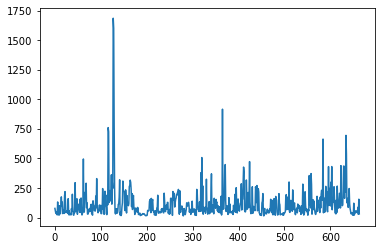

In [204]:
DV_part1['TDV'].plot()

In [207]:
DV_part1.columns

Index(['index', 'ID', 'year', 'Leg', 'matched_seg_id', 'TDV'], dtype='object')

In [208]:
DV_part1['year'].unique()

array([2019., 2016., 2017., 2018.])

In [164]:
# it seems still 1992--456= 1536 sites weekday saily volume still need to be estimated
# use Maximum Weekday AMI_PMI= 5.57710+7.58428e-05* population Density -4.76462* Strava Recreational Ratio

In [165]:
# Now find the short term sites in the weekday where Max_AMI_PMI was not able to calculate due to lack of data
common = weekday_hr_data.merge(DV_part1,on=['ID', 'year', 'Leg'])
sc_weekday=weekday_hr_data[(~weekday_hr_data.ID.isin(common.ID))]
sc_weekday.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff,Lat,Long
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,38.71844,-121.29042
2,3438,3438,6,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,1,E,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
3,3442,3442,10,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,3,S,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
4,3443,3443,11,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,S,...,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,38.71844,-121.29042


In [166]:
weekday_hr_data.shape, sc_weekday.shape, DV_part1.shape

((28226, 27), (19131, 27), (664, 6))

In [167]:
weekday_hr_data['ID'].nunique(),DV_part1['ID'].nunique(),sc_weekday['ID'].nunique()

(1992, 456, 1536)

In [168]:
sc_weekday.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff,Lat,Long
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,38.71844,-121.29042
2,3438,3438,6,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,1,E,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
3,3442,3442,10,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,3,S,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
4,3443,3443,11,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,S,...,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,38.71844,-121.29042


In [169]:
# read Strava recreation ratio data for corresponding short term sites
sc_stv=pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Processed Data/sc_stv_all1.csv')
sc_stv.head(2)

,Unnamed: 0,ID,Leg,year,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio
0,0,CH0,N,2018.0,38.71844,-121.29042,310765851.0,617513986.0,25.0,0.0,25.0,0.00,1.00
1,1,CH1,N,2018.0,38.70660,-121.29038,310761780.0,502915570.0,100.0,35.0,65.0,0.35,0.65


In [170]:
# Calculate the populationden
count_sites=sc_stv
# Use Dr. Frank Code to get population density for each location of the counter within buffer
count_sites['geometry'] = gpd.points_from_xy(count_sites.Long, count_sites.Lat)
count_sites = gpd.GeoDataFrame(count_sites, geometry='geometry', crs='EPSG:4326')
# project the data for geographic analysis
count_sites = count_sites.to_crs(3310)

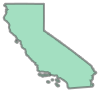

In [84]:
# Calculate the CBD Distance
## Try to pull whole CA state Network using polygon
ca_poly=gpd.read_file('H:/Desktop/AT Census/OSM Bike Network/ca-state-boundary/CA_State_TIGER2016.shp',encoding='utf-8')
ca_poly2=gpd.GeoDataFrame(ca_poly, geometry='geometry', crs='EPSG:3857')
one_mile=1609.34
ca_poly2['geometry'] = ca_poly2['geometry'].buffer(one_mile)
ca_poly3=ca_poly2.to_crs("epsg:4326")
polygon=ca_poly3.loc[0,'geometry']
polygon

In [87]:
# Calculate the CBD distance
#https://wiki.openstreetmap.org/wiki/Tag:amenity%3Dtownhall
# Import University
tags = {'office': 'government'}
city_hall = ox.geometries_from_polygon(polygon, tags)
city_proj = city_hall.to_crs(epsg=3310)

C:\Users\Md Mintu Miah\anaconda3\envs\geo_env\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
C:\Users\Md Mintu Miah\anaconda3\envs\geo_env\lib\site-packages\osmnx\geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


In [185]:
# Consider the rows that have city hall
city_proj1 = city_proj[city_proj['name'].str.contains('City Hall', regex=False, case=False, na=False)]
city_proj2 = city_proj[city_proj['name'].str.contains('Town Hall', regex=False, case=False, na=False)]
city_proj3 = city_proj[city_proj['name'].str.contains('Civic Center', regex=False, case=False, na=False)]
city_proj4 = city_proj[city_proj['name'].str.contains('Administration Building', regex=False, case=False, na=False)]
city_proj5=pd.concat([city_proj1,city_proj2,city_proj3,city_proj4]).reset_index()
city_proj5.head(2)

,element_type,osmid,geometry,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,name,office,...,tourism,suite,name_1,name_2,name_3,building:min_level,police,historic:name,building:use,image
0,way,112118983,"POLYGON ((256114.438 -487436.361, 256128.718 -...",Wildomar,NaN,23873,92595,Clinton Keith Road,Wildomar City Hall,government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,way,121955310,"POLYGON ((265173.826 -498221.861, 265180.761 -...",NaN,NaN,NaN,NaN,NaN,City Hall,government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
# Distance to CBD
count_sites['CBD Distance'] = count_sites.geometry.apply(min_distance_ppoly, args=(city_proj5,))*0.000621371
count_sites=count_sites.reset_index()
count_sites.head(2)

,ID,year,index,Unnamed: 0,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,CBD Distance,popden
0,CH0,2018.0,0,0,N,38.71844,-121.29042,310765851.0,617513986.0,25.0,0.0,25.0,0.00,1.00,POINT (-112076.632 78806.505),14.503799,5039.838905
1,CH1,2018.0,1,1,N,38.70660,-121.29038,310761780.0,502915570.0,100.0,35.0,65.0,0.35,0.65,POINT (-112091.072 77490.506),13.992292,5537.456647


In [187]:
#read Block group
block_groups_CA = gpd.read_file('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Block_Gp/nhgis0101_shape/nhgis0101_shape/nhgis0101_shapefile_tl2019_060_blck_grp_2019/CA_blck_grp_2019.shp')
block_groups_Ne=  gpd.read_file('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Block_Gp/nhgis0101_shape/nhgis0101_shape/nhgis0101_shapefile_tl2019_320_blck_grp_2019/NV_blck_grp_2019.shp')
block_groups=pd.concat([block_groups_CA,block_groups_Ne],axis=0).set_index('GEOID')
block_groups['aland_sqmi'] = block_groups['ALAND'] / (1609.*1609.)
block_groups.head(2)

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry,aland_sqmi
GEOID,,,,,,,,,,,,,,,,
060014001001,G06000104001001,06,001,400100,1,Block Group 1,G5030,S,6894339.0,0.0,+37.8676275,-122.2319460,14302.721555,6.894335e+06,"POLYGON ((-2255602.272 353149.335, -2255597.39...",2.663058
060014002001,G06000104002001,06,001,400200,1,Block Group 1,G5030,S,288069.0,0.0,+37.8497451,-122.2488478,2971.010308,2.880696e+05,"POLYGON ((-2258184.246 353217.527, -2258186.81...",0.111272


In [188]:
bg_pop = pd.read_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Block_Gp/pop/nhgis0102_csv/nhgis0102_ds244_20195_blck_grp.csv')
bg_pop['geoid'] = bg_pop['GEOID'].str[7:]
bg_pop = bg_pop.set_index('geoid')
bg_pop = bg_pop.rename(columns={'ALUBE001': 'pop'})
bg_pop.head(2)

,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,...,SDUNIA,PCI,PUMAA,GEOID,BTTRA,BTBGA,NAME_E,pop,NAME_M,ALUBM001
geoid,,,,,,,,,,,,,,,,,,,,,
060014001001,G06000104001001,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014001001,NaN,NaN,"Block Group 1, Census Tract 4001, Alameda Coun...",3120,"Block Group 1, Census Tract 4001, Alameda Coun...",208
060014002001,G06000104002001,2015-2019,CA,NaN,NaN,California,6,Alameda County,1,NaN,...,NaN,NaN,NaN,15000US060014002001,NaN,NaN,"Block Group 1, Census Tract 4002, Alameda Coun...",990,"Block Group 1, Census Tract 4002, Alameda Coun...",138


In [189]:
block_groups = block_groups.join(bg_pop[['pop']])
# calculate area-weightd average population density - make this a function if needed
count_sites = count_sites.set_index(['ID', 'year'])

block_groups['popden'] = block_groups['pop']/block_groups['aland_sqmi']
block_groups = block_groups.to_crs(3310)

count_sites['buffer_geometry'] = count_sites.buffer(1609.)
count_sites = count_sites.set_geometry('buffer_geometry')

joined_geos = count_sites[['buffer_geometry']].\
    sjoin(block_groups[['geometry']]).\
    join(block_groups[['geometry']], on='index_right')

joined_geos['overlap'] = joined_geos['buffer_geometry'].intersection(joined_geos['geometry']).area

joined_geos['overlap_ratio'] = joined_geos['overlap']/(joined_geos['buffer_geometry'].area)

joined_geos = joined_geos.join(block_groups[['popden']], on='index_right')

joined_geos['weighted_popden'] = joined_geos['overlap_ratio'] * joined_geos['popden']

count_sites['popden'] = joined_geos.groupby(['ID', 'year'])['weighted_popden'].sum()

In [190]:
count_sites = count_sites.set_geometry('geometry').drop(columns='buffer_geometry')

In [191]:
count_sites=count_sites.reset_index()
count_sites.head(2)

,ID,year,index,Unnamed: 0,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,CBD Distance,popden
0,CH0,2018.0,0,0,N,38.71844,-121.29042,310765851.0,617513986.0,25.0,0.0,25.0,0.00,1.00,POINT (-112076.632 78806.505),14.503799,5039.838905
1,CH1,2018.0,1,1,N,38.70660,-121.29038,310761780.0,502915570.0,100.0,35.0,65.0,0.35,0.65,POINT (-112091.072 77490.506),13.992292,5537.456647


In [194]:
# separate 2019 and 2018 data as it has strava 
count_sites1=count_sites[(count_sites['year']==2019)|(count_sites['year']==2018)]
count_sites1.head()

,ID,year,index,Unnamed: 0,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,CBD Distance,popden
0,CH0,2018.0,0,0,N,38.718440,-121.290420,310765851.0,617513986.0,25.0,0.0,25.0,0.000000,1.000000,POINT (-112076.632 78806.505),14.503799,5039.838905
1,CH1,2018.0,1,1,N,38.706600,-121.290380,310761780.0,502915570.0,100.0,35.0,65.0,0.350000,0.650000,POINT (-112091.072 77490.506),13.992292,5537.456647
2,CH2,2018.0,2,2,N,38.714370,-121.290390,310762075.0,567434031.0,25.0,25.0,0.0,1.000000,0.000000,POINT (-112080.185 78354.113),14.325443,5264.392231
3,Kern70,2018.0,3,3,N,35.410707,-118.934641,308525496.0,680383811.0,2530.0,120.0,2410.0,0.047431,0.952569,POINT (96661.372 -289037.062),66.366896,2504.658659
4,Kern75,2018.0,4,4,W,35.397944,-118.930790,308524545.0,125436390.0,290.0,10.0,280.0,0.034483,0.965517,POINT (97026.705 -290450.543),65.572678,2985.600914


In [209]:
count_sites1.shape

(815, 18)

# Now estimate Weekday Max AMI_PMI using Maximum Weekday AMI_PMI= -1.47873+0.72594* 𝐥𝐧("population Density")-4.29025*(〖"Strava Recreational Ratio)" 〗^𝟐+𝟎.𝟑𝟑𝟒𝟎𝟒∗𝐥𝐧(𝐃𝐢𝐬𝐭𝐚𝐧𝐜𝐞 𝐭𝐨 𝐂𝐁𝐃 𝐢𝐧 𝐦𝐢𝐥𝐞)


In [220]:
a=0.394208513
b= 0.58077955
c= -4.12728237
count_sites1['Max_AMI_PMI']=a+b*np.log(count_sites1['popden'])+c*np.power(count_sites1['stv_rec_ratio'],2)
count_sites1.head(3)

C:\Users\Md Mintu Miah\anaconda3\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,ID,year,index,Unnamed: 0,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,CBD Distance,popden,Max_AMI_PMI
0,CH0,2018.0,0,0,N,38.71844,-121.29042,310765851.0,617513986.0,25.0,0.0,25.0,0.00,1.00,POINT (-112076.632 78806.505),14.503799,5039.838905,1.218147
1,CH1,2018.0,1,1,N,38.70660,-121.29038,310761780.0,502915570.0,100.0,35.0,65.0,0.35,0.65,POINT (-112091.072 77490.506),13.992292,5537.456647,3.656339
2,CH2,2018.0,2,2,N,38.71437,-121.29039,310762075.0,567434031.0,25.0,25.0,0.0,1.00,0.00,POINT (-112080.185 78354.113),14.325443,5264.392231,5.370746


In [221]:
count_sites1['Max_AMI_PMI'].describe()

count    735.000000
mean       2.305457
std        1.623128
min       -2.076317
25%        0.941241
50%        2.273330
75%        3.523876
max        5.639343
Name: Max_AMI_PMI, dtype: float64

In [218]:
# Strava is missing for 2016 and 2017, therefore,now use Maximum Weekday AMI_PMI= -0.32406+0.03444*√("population Density" ) +𝟎.𝟎𝟒𝟐𝟖𝟑∗𝐥𝐧(𝐃𝐢𝐬𝐭𝐚𝐧𝐜𝐞 𝐭𝐨 𝐂𝐁𝐃 𝐢𝐧 𝐦𝐢𝐥𝐞) to 
#calculate max AMI_PMI for 2016 and 2017 data 
count_sites2=count_sites[(count_sites['year']==2016)|(count_sites['year']==2017)]
a=-0.32406
b=0.03444
c=0.04283
count_sites2['Max_AMI_PMI']=a+b*np.sqrt(count_sites2['popden'])+c*np.log(count_sites2['CBD Distance'])
count_sites2.head()

C:\Users\Md Mintu Miah\anaconda3\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,ID,year,index,Unnamed: 0,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,CBD Distance,popden,Max_AMI_PMI
815,CH33,2016.0,815,19,N,38.69575,-121.26919,310797458.0,10507917.0,NaN,NaN,NaN,NaN,NaN,POINT (-110266.628 76259.750),14.499686,5747.314076,2.401405
816,CH34,2016.0,816,20,N,38.70045,-121.26244,310798228.0,530730915.0,NaN,NaN,NaN,NaN,NaN,POINT (-109673.279 76774.311),14.981567,5526.284064,2.352108
817,CH35,2016.0,817,21,N,38.66973,-121.28464,310670023.0,965928012.0,NaN,NaN,NaN,NaN,NaN,POINT (-111648.027 73385.817),12.875724,6284.000212,2.515502
818,CH36,2016.0,818,22,N,38.66382,-121.28461,310669935.0,10500789.0,NaN,NaN,NaN,NaN,NaN,POINT (-111654.322 72728.910),12.692579,5461.086301,2.329859
819,CH37,2016.0,819,23,N,38.70046,-121.25426,310798370.0,530730915.0,NaN,NaN,NaN,NaN,NaN,POINT (-108962.669 76765.993),15.355198,5112.178477,2.255371


In [219]:
count_sites2['Max_AMI_PMI'].describe()

count    1310.000000
mean        2.224841
std         1.090206
min        -0.091375
25%         1.493449
50%         2.092024
75%         2.862085
max         6.840702
Name: Max_AMI_PMI, dtype: float64

In [227]:
sc_weekday.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff,Lat,Long
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,38.71844,-121.29042
2,3438,3438,6,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,1,E,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
3,3442,3442,10,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,3,S,...,Week Day,07:00:00,08:00:00,NaN,NaN,2018-05-30 07:00:00,2018-05-30 08:00:00,1.0,38.71844,-121.29042
4,3443,3443,11,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,S,...,Week Day,08:00:00,09:00:00,NaN,NaN,2018-05-30 08:00:00,2018-05-30 09:00:00,1.0,38.71844,-121.29042


In [241]:
# Now combine count_sites1 and count sites 2 data
count_sites3=pd.concat([count_sites1,count_sites2],axis=0)
count_sites4=pd.merge(sc_weekday,count_sites3,on=['ID','year'], how='inner')
count_sites4.shape

(19024, 43)

In [242]:
count_sites4.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0_x', 'ID', 'Date',
       'Day of Week', 'Start Time', 'End Time', 'Count', 'Leg_x',
       'matched_seg_id', 'date', 'month', 'year', 'day', 'dayofweek',
       'weekday_Status', 'Week Day Status', 'starttime', 'endtime',
       'starttime1', 'endtime1', 'startDateTime', 'endDateTime', 'diff',
       'Lat_x', 'Long_x', 'index', 'Unnamed: 0_y', 'Leg_y', 'Lat_y', 'Long_y',
       'edgeUID', 'osmId', 'stv_total', 'stv_com_total', 'stv_rec_total',
       'stv_com_ratio', 'stv_rec_ratio', 'geometry', 'CBD Distance', 'popden',
       'Max_AMI_PMI'],
      dtype='object')

In [243]:
count_sites4=count_sites4.rename(columns={"Leg_x":'Leg'})

In [244]:
sc_weekday.shape,count_sites3.shape

((19131, 27), (2130, 18))

In [245]:
sc_weekday['ID'].nunique(),count_sites4['ID'].nunique()

(1536, 1536)

In [246]:
# split by MAX AMI_PMI Value
m_g1=count_sites4.loc[count_sites4['Max_AMI_PMI']<=1]
m_g2=count_sites4[(count_sites4.Max_AMI_PMI>1) &(count_sites4.Max_AMI_PMI<=2.50)]
m_g3=count_sites4.loc[count_sites4['Max_AMI_PMI']>2.50]
m_g3.head(2)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0_x,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,CBD Distance,popden,Max_AMI_PMI
19,3451,3451,19,CH1,2018-05-30,Wednesday,7:00 AM,8:00 AM,1,N,...,502915570.0,100.0,35.0,65.0,0.35,0.65,POINT (-112091.072 77490.506),13.992292,5537.456647,3.656339
20,3452,3452,20,CH1,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,502915570.0,100.0,35.0,65.0,0.35,0.65,POINT (-112091.072 77490.506),13.992292,5537.456647,3.656339


In [247]:
m_g3.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0_x', 'ID', 'Date',
       'Day of Week', 'Start Time', 'End Time', 'Count', 'Leg',
       'matched_seg_id', 'date', 'month', 'year', 'day', 'dayofweek',
       'weekday_Status', 'Week Day Status', 'starttime', 'endtime',
       'starttime1', 'endtime1', 'startDateTime', 'endDateTime', 'diff',
       'Lat_x', 'Long_x', 'index', 'Unnamed: 0_y', 'Leg_y', 'Lat_y', 'Long_y',
       'edgeUID', 'osmId', 'stv_total', 'stv_com_total', 'stv_rec_total',
       'stv_com_ratio', 'stv_rec_ratio', 'geometry', 'CBD Distance', 'popden',
       'Max_AMI_PMI'],
      dtype='object')

In [248]:
# Apply factor to obtain daily Volume
mg1_DV=pd.merge(m_g1,HOD_weekday_g1, on=['starttime'], how='inner')
mg1_DV['Daily_Volume']=mg1_DV['Count']/mg1_DV['Average_Group_HOD_Factor']
mg1_DV1=pd.DataFrame({'TDV' : mg1_DV.groupby(['ID','year','Leg','matched_seg_id'])['Daily_Volume'].mean()}).reset_index()
mg2_DV=pd.merge(m_g2,HOD_weekday_g2, on=['starttime'], how='inner')
mg2_DV['Daily_Volume']=mg2_DV['Count']/mg2_DV['Average_Group_HOD_Factor']
mg2_DV2=pd.DataFrame({'TDV' : mg2_DV.groupby(['ID','year','Leg','matched_seg_id'])['Daily_Volume'].mean()}).reset_index()
mg3_DV=pd.merge(m_g3,HOD_weekday_g3, on=['starttime'], how='inner')
mg3_DV['Daily_Volume']=mg3_DV['Count']/mg3_DV['Average_Group_HOD_Factor']
mg3_DV3=pd.DataFrame({'TDV' : mg3_DV.groupby(['ID','year','Leg','matched_seg_id'])['Daily_Volume'].mean()}).reset_index()
mg3_DV3.head()

,ID,year,Leg,matched_seg_id,TDV
0,AC20160,2016.0,E,155482,177.626998
1,AC20160,2016.0,N,155481,72.563300
2,AC20160,2016.0,S,155480,74.811691
3,AC20160,2016.0,W,155626,197.056330
4,AC20161,2016.0,E,151225,6.831817


In [249]:
# combine these three group of estimated daily volume together
DV_part2=pd.concat([mg1_DV1,mg2_DV2,mg3_DV3],axis=0).reset_index()
DV_part2.shape

(4353, 6)

In [250]:
DV_part2.head()

,index,ID,year,Leg,matched_seg_id,TDV
0,0,AC201624,2016.0,E,one-way road,0.000000
1,1,AC201624,2016.0,N,154970,46.003343
2,2,AC201624,2016.0,S,154968,79.157342
3,3,AC201624,2016.0,W,154967,46.003343
4,4,AC201639,2016.0,E,154438,26.157651


<AxesSubplot:>

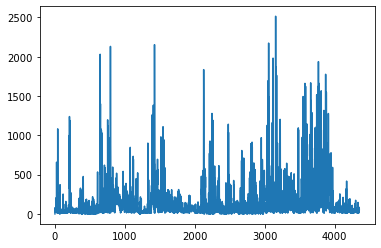

In [251]:
DV_part2['TDV'].plot()

In [252]:
# Combine all Estimated weekday Daily Volume
Weekday_DV=pd.concat([DV_part1,DV_part2],axis=0)
Weekday_DV.shape

(5017, 6)

In [253]:
Weekday_DV['ID'].nunique()

1795

# Now Estimate weekend Daily Volume

In [254]:
weekend_hr_data.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,Week Day Status,starttime,endtime,starttime1,endtime1,startDateTime,endDateTime,diff,Lat,Long
1086,4676,4676,446,Kern7,2016-12-17,Saturday,7:00 AM,8:00 AM,4,N,...,Weekend,07:00:00,08:00:00,NaN,NaN,2016-12-17 07:00:00,2016-12-17 08:00:00,1.0,35.365131,-118.93197
1087,4677,4677,447,Kern7,2016-12-17,Saturday,8:00 AM,9:00 AM,1,N,...,Weekend,08:00:00,09:00:00,NaN,NaN,2016-12-17 08:00:00,2016-12-17 09:00:00,1.0,35.365131,-118.93197
1088,4678,4678,448,Kern7,2016-12-17,Saturday,9:00 AM,10:00 AM,2,N,...,Weekend,09:00:00,10:00:00,NaN,NaN,2016-12-17 09:00:00,2016-12-17 10:00:00,1.0,35.365131,-118.93197
1089,4679,4679,449,Kern7,2016-12-17,Saturday,10:00 AM,11:00 AM,4,N,...,Weekend,10:00:00,11:00:00,NaN,NaN,2016-12-17 10:00:00,2016-12-17 11:00:00,1.0,35.365131,-118.93197
1095,4680,4680,450,Kern7,2016-12-17,Saturday,12:00 PM,1:00 PM,1,N,...,Weekend,12:00:00,13:00:00,NaN,NaN,2016-12-17 12:00:00,2016-12-17 13:00:00,1.0,35.365131,-118.93197


In [255]:
count_sites.head()

,ID,year,index,Unnamed: 0,Leg,Lat,Long,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,CBD Distance,popden
0,CH0,2018.0,0,0,N,38.718440,-121.290420,310765851.0,617513986.0,25.0,0.0,25.0,0.000000,1.000000,POINT (-112076.632 78806.505),14.503799,5039.838905
1,CH1,2018.0,1,1,N,38.706600,-121.290380,310761780.0,502915570.0,100.0,35.0,65.0,0.350000,0.650000,POINT (-112091.072 77490.506),13.992292,5537.456647
2,CH2,2018.0,2,2,N,38.714370,-121.290390,310762075.0,567434031.0,25.0,25.0,0.0,1.000000,0.000000,POINT (-112080.185 78354.113),14.325443,5264.392231
3,Kern70,2018.0,3,3,N,35.410707,-118.934641,308525496.0,680383811.0,2530.0,120.0,2410.0,0.047431,0.952569,POINT (96661.372 -289037.062),66.366896,2504.658659
4,Kern75,2018.0,4,4,W,35.397944,-118.930790,308524545.0,125436390.0,290.0,10.0,280.0,0.034483,0.965517,POINT (97026.705 -290450.543),65.572678,2985.600914


In [256]:
weekend_hr_data.shape, count_sites.shape

((2468, 27), (2130, 17))

In [257]:
weekend_hr_data1=pd.merge(weekend_hr_data,count_sites,on=['ID','year'], how='inner')
weekend_hr_data1.shape

(2462, 42)

In [258]:
weekend_hr_data1.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0_x,ID,Date,Day of Week,Start Time,End Time,Count,Leg_x,...,edgeUID,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,CBD Distance,popden
0,4676,4676,446,Kern7,2016-12-17,Saturday,7:00 AM,8:00 AM,4,N,...,308518631.0,10411960.0,NaN,NaN,NaN,NaN,NaN,POINT (96960.699 -294095.797),63.97986,5554.147258
1,4677,4677,447,Kern7,2016-12-17,Saturday,8:00 AM,9:00 AM,1,N,...,308518631.0,10411960.0,NaN,NaN,NaN,NaN,NaN,POINT (96960.699 -294095.797),63.97986,5554.147258
2,4678,4678,448,Kern7,2016-12-17,Saturday,9:00 AM,10:00 AM,2,N,...,308518631.0,10411960.0,NaN,NaN,NaN,NaN,NaN,POINT (96960.699 -294095.797),63.97986,5554.147258
3,4679,4679,449,Kern7,2016-12-17,Saturday,10:00 AM,11:00 AM,4,N,...,308518631.0,10411960.0,NaN,NaN,NaN,NaN,NaN,POINT (96960.699 -294095.797),63.97986,5554.147258
4,4680,4680,450,Kern7,2016-12-17,Saturday,12:00 PM,1:00 PM,1,N,...,308518631.0,10411960.0,NaN,NaN,NaN,NaN,NaN,POINT (96960.699 -294095.797),63.97986,5554.147258


In [259]:
weekend_hr_data2=weekend_hr_data1.rename(columns={"Leg_x":'Leg'})

In [260]:
# Split the weekend data by strava recreational threshold to apply factor
w_g1=weekend_hr_data2.loc[weekend_hr_data2['stv_rec_ratio']<=0.75]
w_g2=weekend_hr_data2.loc[weekend_hr_data2['stv_rec_ratio']>0.75]
m_g2.head(2)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0_x,ID,Date,Day of Week,Start Time,End Time,Count,Leg,...,osmId,stv_total,stv_com_total,stv_rec_total,stv_com_ratio,stv_rec_ratio,geometry,CBD Distance,popden,Max_AMI_PMI
0,3432,3432,0,CH0,2018-05-30,Wednesday,7:00 AM,8:00 AM,4,N,...,617513986.0,25.0,0.0,25.0,0.0,1.0,POINT (-112076.632 78806.505),14.503799,5039.838905,1.218147
1,3433,3433,1,CH0,2018-05-30,Wednesday,8:00 AM,9:00 AM,4,N,...,617513986.0,25.0,0.0,25.0,0.0,1.0,POINT (-112076.632 78806.505),14.503799,5039.838905,1.218147


In [269]:
# Split the factor by criteria
HOD_weekend=HOD.loc[HOD['day_of_status']=='weekend']
HOD_weekend_g1=HOD_weekend.loc[HOD_weekend['Criteria']=='Average_stv_rec_ratio<=0.75']
HOD_weekend_g2=HOD_weekend.loc[HOD_weekend['Criteria']=='Average_stv_rec_ratio>0.75']
HOD_weekend_g1.head()

,Unnamed: 0,starttime,Average_Group_HOD_Factor,Criteria,day_of_status
72,0,00:00:00,0.012068,Average_stv_rec_ratio<=0.75,weekend
73,1,01:00:00,0.007182,Average_stv_rec_ratio<=0.75,weekend
74,2,02:00:00,0.005637,Average_stv_rec_ratio<=0.75,weekend
75,3,03:00:00,0.003976,Average_stv_rec_ratio<=0.75,weekend
76,4,04:00:00,0.003748,Average_stv_rec_ratio<=0.75,weekend


In [267]:
HOD_weekend['Criteria'].unique()

array(['Average_stv_rec_ratio>0.75'], dtype=object)

In [270]:
# Apply factor to obtain daily Volume
wg1_DV=pd.merge(w_g1,HOD_weekend_g1, on=['starttime'], how='inner')
wg1_DV['Daily_Volume']=wg1_DV['Count']/wg1_DV['Average_Group_HOD_Factor']
wg1_DV1=pd.DataFrame({'TDV' : wg1_DV.groupby(['ID','year','Leg','matched_seg_id'])['Daily_Volume'].mean()}).reset_index()
wg2_DV=pd.merge(w_g2,HOD_weekend_g2, on=['starttime'], how='inner')
wg2_DV['Daily_Volume']=wg2_DV['Count']/wg2_DV['Average_Group_HOD_Factor']
wg2_DV2=pd.DataFrame({'TDV' : wg2_DV.groupby(['ID','year','Leg','matched_seg_id'])['Daily_Volume'].mean()}).reset_index()

In [273]:
# combine these three group of estimated daily volume together
Weekend_DV=pd.concat([wg1_DV1,wg2_DV2],axis=0).reset_index()
Weekend_DV.shape

(132, 6)

<AxesSubplot:>

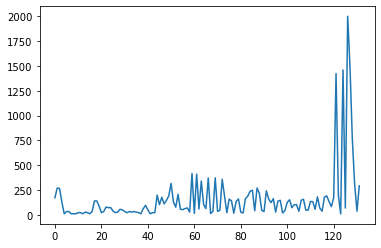

In [274]:
Weekend_DV['TDV'].plot()

# Combine weekday and weekend Estimated Daily Volume

In [275]:
ES_DV=pd.concat([Weekday_DV, Weekend_DV],axis=0).reset_index()
ES_DV.head()

,level_0,index,ID,year,Leg,matched_seg_id,TDV
0,0,0,CH17,2019.0,E,89834,77.418452
1,1,1,CH17,2019.0,N,89833,55.259502
2,2,2,CH17,2019.0,S,89698,35.149290
3,3,3,CH23,2019.0,N,89504,34.628136
4,4,4,CH25,2019.0,S,bearing calculation not match with TMS count,47.098246


In [276]:
ES_DV['ID'].nunique()

1834

In [277]:
ES_DV.to_csv('C:/UC Berkeley Project Backup/Bike_ped Exposure Model Project/Estimated_Outcomes/Estimated_SC_DV.csv')